In [61]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [17]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition


### Load the data

In [18]:
file_name = "final_df"

In [19]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [20]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [21]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [22]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Training-Test split

In [49]:
def train_test_split_df(df, test_perc): 
    
    n_classes = df['category'].nunique()
    
    n_samples = int(len(df)*test_perc/n_classes)
    
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)
    
    train_df = df.drop(test_df.index)
    
    return train_df, test_df

In [50]:
train_df, test_df = train_test_split_df(df, 0.2)

15
168


### Tensorflow Dataset

In [24]:
def create_dataset(df, batch_size, use_object=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    # merge the two arrays
    if use_object:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    else:
        df['input'] = df['keypoints']

    if use_object:
        data = np.zeros((len(kpoints), 17*3+100))
    else:    
        data = np.zeros((len(kpoints), 17*3))
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset

### Define the model

In [37]:
def create_model(use_object=True, summary=False):
    
    if use_object:
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(17*3+100,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(15, activation='softmax')
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(17*3,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(15, activation='softmax')
        ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    if summary:
        model.summary()
    
    return model


In [38]:
model = create_model(summary=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 128)               19456     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                                 
 dense_68 (Dense)            (None, 64)                4160      
                                                                 
 dense_69 (Dense)            (None, 32)                2080      
                                                                 
 dense_70 (Dense)            (None, 32)                1056      
                                                                 
 dense_71 (Dense)            (None, 15)              

In [ ]:
def plot_train(results):
    
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']
    
    t = np.arange(len(train_accuracy))
    
    print('Stopped at epoch ', len(train_accuracy))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()
    

Starting Fold Number  1

Fitting the model:

Stopped at epoch  39


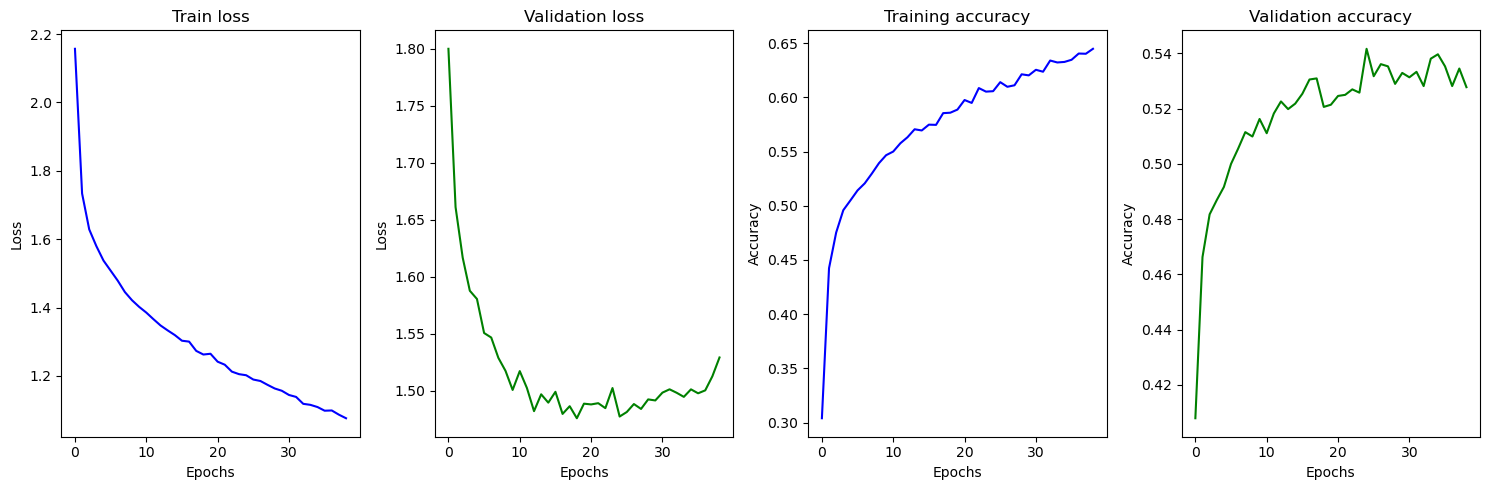

79/79 [==============================] - 0s 841us/step - loss: 1.5293 - accuracy: 0.5278

-----------------------------------------------------------------

Starting Fold Number  2

Fitting the model:

Stopped at epoch  47


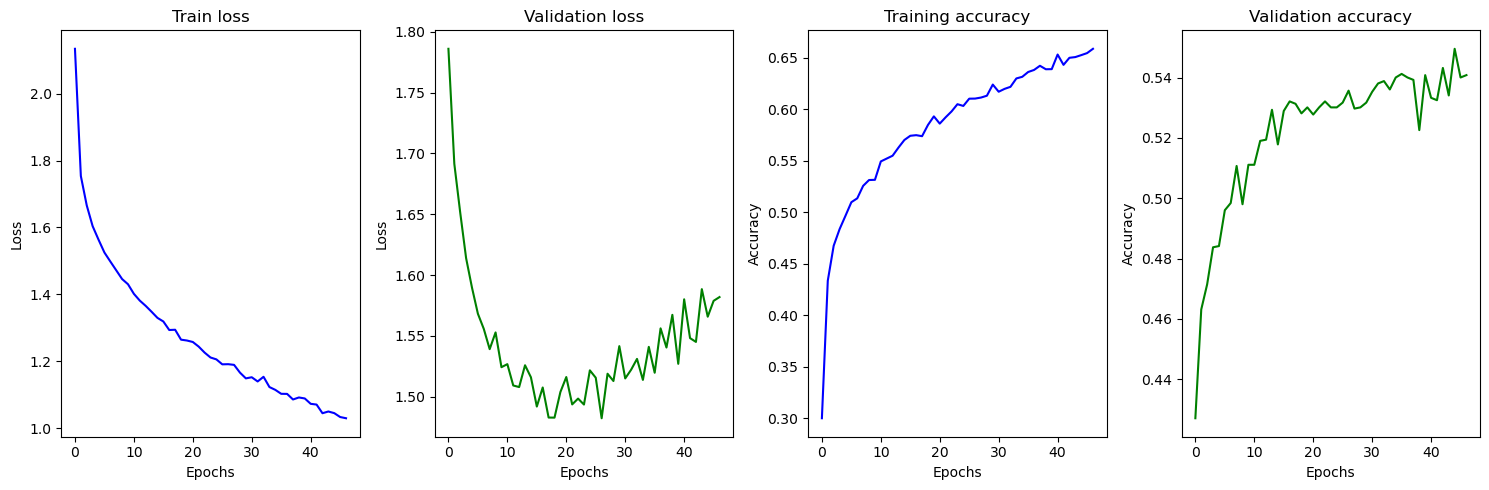

79/79 [==============================] - 0s 703us/step - loss: 1.5819 - accuracy: 0.5409

-----------------------------------------------------------------

Starting Fold Number  4

Fitting the model:

Stopped at epoch  48


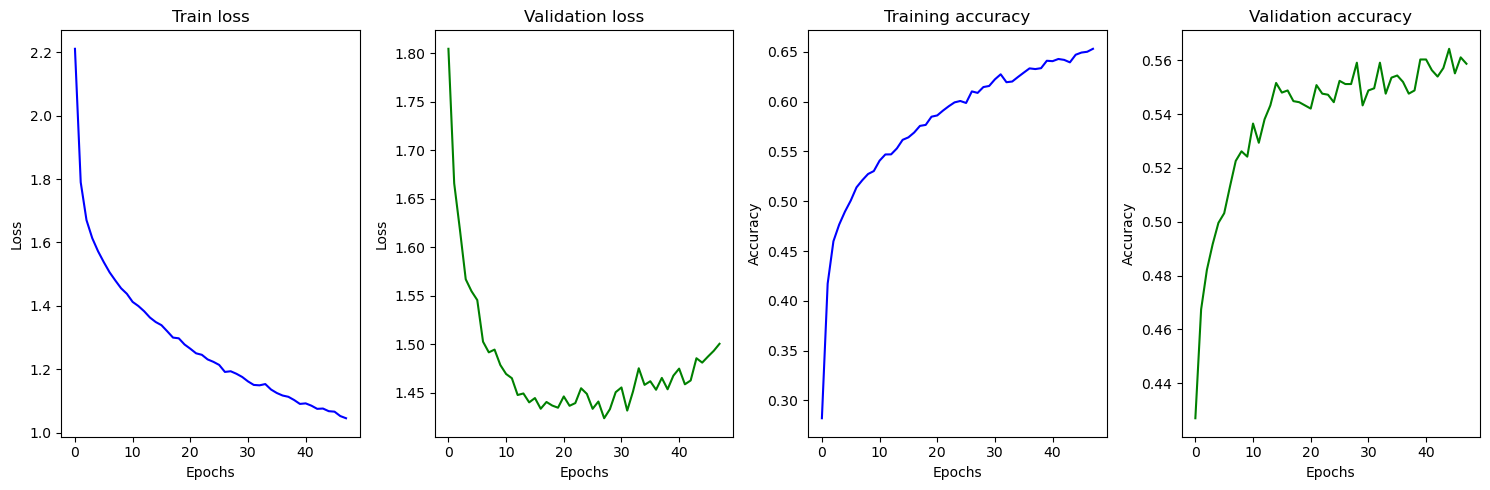

79/79 [==============================] - 0s 696us/step - loss: 1.5005 - accuracy: 0.5587

-----------------------------------------------------------------

Starting Fold Number  8

Fitting the model:

Stopped at epoch  50


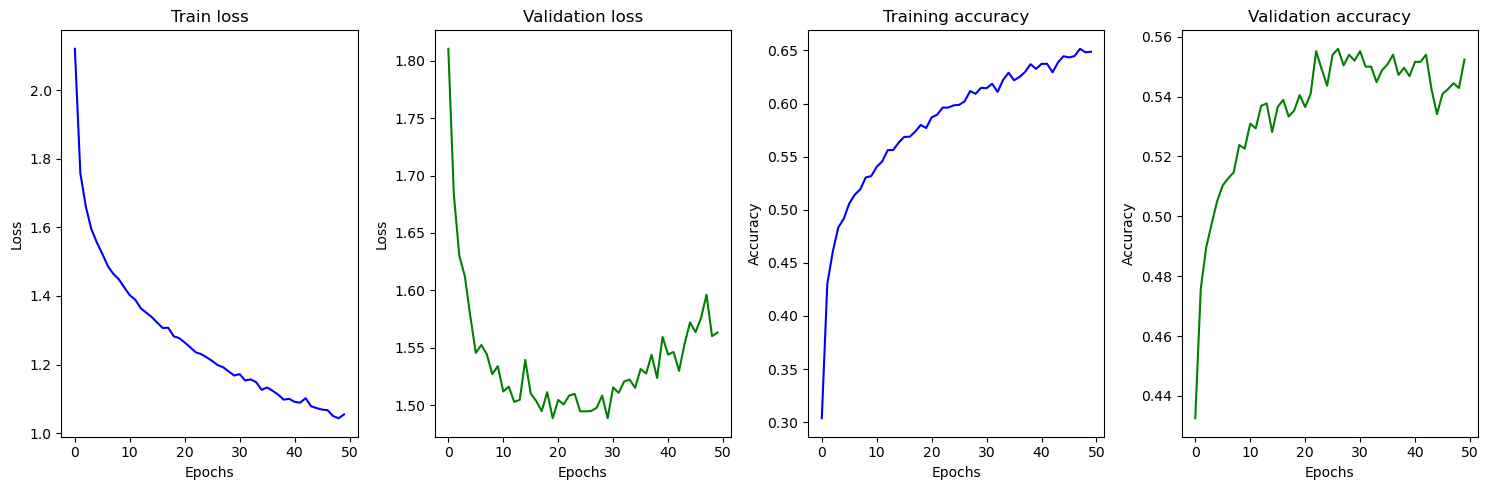

79/79 [==============================] - 0s 1ms/step - loss: 1.5633 - accuracy: 0.5524

-----------------------------------------------------------------

Starting Fold Number  16

Fitting the model:

Stopped at epoch  36


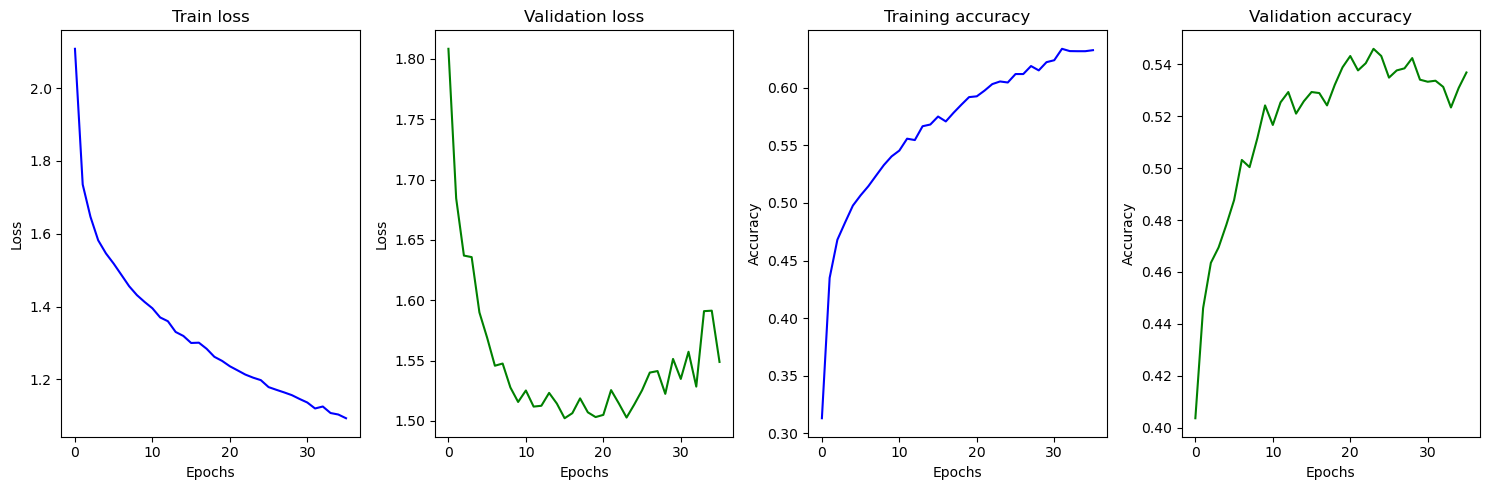

79/79 [==============================] - 0s 654us/step - loss: 1.5489 - accuracy: 0.5369

-----------------------------------------------------------------



In [55]:
# Number of folds
n_splits = 5
batch_s = 32
index = 1

# KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))


for train_index, val_index in kf.split(df):
    
    print("Starting Fold Number ", index)
    print()
    
    index += index
    
    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset = create_dataset(df_train, batch_s)
    val_dataset = create_dataset(df_val, batch_s)
    
    print("Fitting the model:")
    print()
    
    # Create a new instance of the model
    model = create_model()
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    results = model.fit(train_dataset,
                        epochs=1000,
                        validation_data=val_dataset, 
                        callbacks=[early_stop_callback], verbose = 0)

    
    plot_train(results)
    
    # compute predicted labels
    output_vector = model.predict(val_dataset)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    extracted_labels = []
    for _, label in val_dataset:
        extracted_labels.extend(label.numpy().tolist())

    true_labels = np.array(extracted_labels)
    
    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_dataset)
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

In [56]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [57]:
# Normalize the confusion matrix by row (i.e., by the number of samples in each actual class) 
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] # 

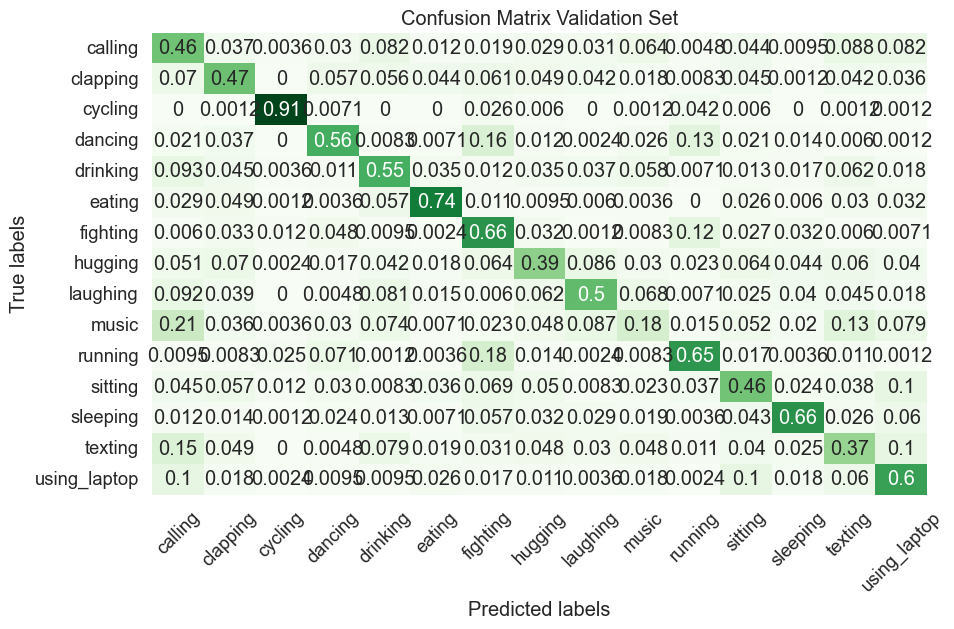

In [60]:
plt.figure(figsize=(10, 6))

sns.set(font_scale=1.2)  # Adjust font size

sns.heatmap(conf_matrix_normalized , annot=True, cmap="Greens", cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xticks(rotation=45)

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.title('Confusion Matrix Validation Set')

plt.show()

### Analyze the results

In [64]:
def class_specific_metrics(cm, class_labels = labels):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [65]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.904762,0.464286,0.936224,0.342105
clapping,0.931825,0.471429,0.964711,0.488286
cycling,0.989444,0.908333,0.995238,0.931624
dancing,0.947381,0.557143,0.975255,0.616601
drinking,0.935635,0.554762,0.962840,0.516058
eating,0.966984,0.736905,0.983418,0.760442
fighting,0.928254,0.655952,0.947704,0.472556
hugging,0.930238,0.389286,0.968878,0.471861
laughing,0.942143,0.496429,0.973980,0.576763
music,0.919048,0.178571,0.971939,0.312500
